# Supernova use case notebook

ALeRCE starter notebook for supernova science.

You will need the alerce API wrapper

In this notebook you will use the ALeRCE API to download some objects with probability greater than 0.7 of being supernova, get selected light curves and plot, as well as querying NED for galaxy crossmatches and displaying in Aladin.

### Load libraries

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets

Import alerce api wrapper

In [2]:
#!pip install alerce_api
from alerce_api import *
alerce = AlerceAPI()

Astroquery https://astroquery.readthedocs.io/en/latest/

In [3]:
#!pip install astroquery
from astroquery.ned import Ned

Install pyaladin https://github.com/cds-astro/ipyaladin

In [4]:
# you may need to restart the notebook after running the following lines
#!pip install ipyaladin
#!jupyter nbextension enable --py widgetsnbextension
#!jupyter nbextension enable --py --sys-prefix ipyaladin

In [5]:
import ipyaladin as ipyal # see installation instructions here: https://github.com/cds-astro/ipyaladin

Show alerce.query help

In [6]:
help(alerce.query)

Help on method query in module alerce_api.api:

query(params) method of alerce_api.api.AlerceAPI instance
    Query the ALeRCE API to get matching objects into a pandas dataframe.
    
    The current fields to query the db are the following:
    
    {
    total: number (if not set the total is counted and the query is slower),
    records_per_pages: number (default 20),
    page: number (default 1),
    sortBy: string columnName (default nobs),
    query_parameters:{
       filters:{
          //ZTF Object id
          oid: "ZTFXXXXXX",
          //Number of detections
          nobs: { 
              min: int
              max: int
          },
          //Late Classifier (Random Forest)
          classrf: ["CEPH","DSCT","EB","LPV","RRL","SNe","Other"] or int,
          pclassrf: float [0-1],
          //Early Classifier (Stamp Classifier)
          classearly: ["AGN","SN","VS","asteroid","bogus"] or int,
          pclassearly: float [0-1],
          },
          //Coordinate based 

### Query top 100 SNe which exploded at least 70 days after ZTF's 1st light, that have a probability > 0.8 of being a SNe, and which have between 10 and 40 detections

In [7]:
total = 100
records_per_page = 100
page = 1
sortBy = "pclassrf"
classrf = "SNe"
pclassrf = 0.8
min_nobs = 10
max_nobs = 50
min_firstmjd = Time("2017-11-01T00:00:00", format="isot", scale="utc").mjd + 70

params = {
    #"total": total,
    "records_per_pages": records_per_page,
    "page": page,
    "sortBy": sortBy,
    "query_parameters": {
        "filters": {
            "nobs": {
                "min": min_nobs,
                "max": max_nobs
            },
            "firstmjd": { 
                "min": min_firstmjd,
            },
            "classrf": classrf,
            "pclassrf": pclassrf
        }
    }
}

In [8]:
SNe = alerce.query(params)
print(SNe.shape)
SNe.head()

(100, 43)


,catalogid,classearly,classrf,classxmatch,deltajd,first_magap_g,first_magap_r,first_magpsf_g,first_magpsf_r,firstmjd,...,nobs,pclassearly,pclassrf,period,sigma_magap_g,sigma_magap_r,sigma_magpsf_g,sigma_magpsf_r,sigmadec,sigmara
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18aapgrxo,4.0,None,6,6.0,443.887419,18.650600,19.039301,18.592459,18.814985,58272.394143,...,39,NaN,0.868,None,0.530701,0.554815,0.545823,0.609931,0.000023,0.000049
ZTF18aauxltf,4.0,SN,6,6.0,452.835602,19.247101,18.006800,19.280064,18.150463,58270.317037,...,43,0.999487,0.868,None,0.143544,0.634277,0.047683,0.533838,0.000030,0.000021
ZTF18aaxokeg,NaN,SN,6,NaN,54.988646,18.817101,18.303600,18.750341,18.322269,58606.207986,...,23,0.999982,0.882,None,1.029636,0.718011,0.963688,0.655578,0.000021,0.000026
ZTF18aazixbw,4.0,None,6,6.0,55.929734,19.430599,19.629499,19.526386,19.507538,58281.265220,...,20,NaN,0.878,None,0.579066,0.818429,0.570525,0.727008,0.000052,0.000054
ZTF18abdefet,4.0,None,6,6.0,42.991123,19.413300,19.378799,19.263947,19.193773,58300.340139,...,15,NaN,0.874,None,0.261308,0.646313,0.240934,0.467444,0.000026,0.000060


### Create function to plot SN light curve

In [9]:
def plotLC(oid, SN_det, SN_nondet):
    fig, ax = plt.subplots(figsize = (14, 7))
    labels = {1: 'g', 2: 'r'}
    colors = {1: 'g', 2: 'r'}
    for fid in [1, 2]:
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:
            # detections index is candid
            ax.errorbar(SN_det[mask].mjd, SN_det[mask].magpsf_corr, 
                yerr = SN_det[mask].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid])
        mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        if np.sum(mask) > 0:            
            # non detections index is mjd
            ax.scatter(SN_nondet[mask].index, SN_nondet[mask].diffmaglim, c = colors[fid], alpha = 0.5,
                marker = 'v', label = "lim.mag. %s" % labels[fid])
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

### Create function to get data and plot SN light curve

In [10]:
def getSNdata(oid, doLC = False, dostamp = False, doNED = False):

    results = {}
    
    # query basic stats
    SN_stats = alerce.get_stats(oid)
    
    # query detections
    SN_det = alerce.get_detections(oid)
    results["LC_det"] = SN_det
        
    # query non detections
    SN_nondet = alerce.get_non_detections(oid)
    results["LC_nondet"] = SN_nondet
    
    if doLC:
        plotLC(oid, SN_det, SN_nondet)
        
    # find NED galaxies
    if doNED:
        co = coordinates.SkyCoord(ra=SNe.meanra[oid], dec=SNe.meandec[oid], unit=(u.deg, u.deg), frame='fk5')
        Ned_table = Ned.query_region(co, radius=0.01 * u.deg, equinox='J2000.0')
        display(Ned_table)
        results["Ned_table"] = Ned_table
                
    if dostamp:
        alerce.plot_stamp(oid)
        

    # return data
    return results

### Get the brightest SN

In [11]:
seloid = SNe.min_magpsf_g.idxmin()
print(seloid)

ZTF19aavrswr


### Do one SN with NED and Aladin

ZTF19aansyyn


No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,bytes30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,SDSS J144649.42+374711.5,221.70592,37.78653,*,--,--,,23.7g,0.41,0,0,5,1,0,4,0
2,SDSS J144649.65+374750.9,221.7069,37.79747,*,--,--,,22.6g,0.539,0,0,5,1,0,4,0
3,SDSS J144650.04+374659.7,221.70851,37.78326,G,--,--,,21.8g,0.468,0,0,15,1,0,4,0
4,SDSS J144650.17+374746.7,221.70907,37.79633,G,--,--,,22.6g,0.426,0,0,15,1,0,4,0
5,SDSS J144651.09+374702.2,221.7129,37.78396,G,--,--,,21.5g,0.367,0,0,15,1,0,4,0
6,2MASS J14465146+3747144,221.71447,37.78744,G,--,--,,19.0g,0.167,0,0,21,2,0,4,0
7,SDSS J144653.35+374702.6,221.72231,37.78408,G,--,--,,22.9g,0.557,0,0,15,1,0,4,0
8,SDSS J144653.60+374733.3,221.72337,37.79261,G,--,--,,23.4g,0.5,0,0,15,1,0,3,0


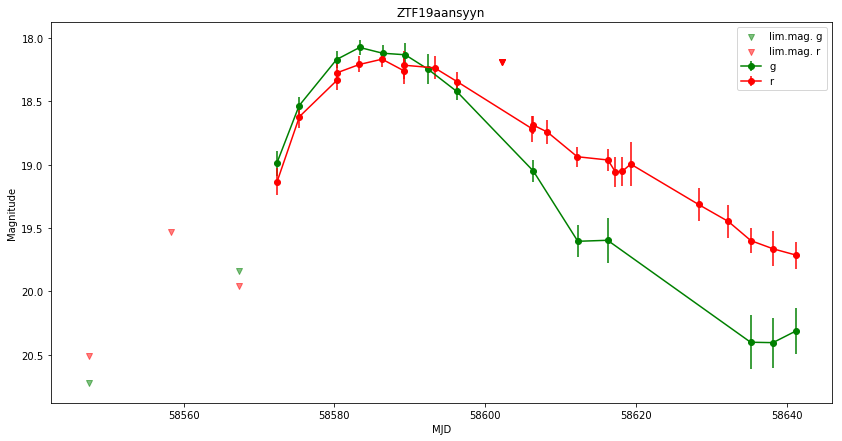

In [12]:
seloid = np.random.choice(SNe.index)
print(seloid)
results = getSNdata(seloid, doLC=True, dostamp=True, doNED=True);
LC_det = results["LC_det"]
LC_nondet = results["LC_nondet"]
Ned_table = results["Ned_table"]

# Use Aladin to show nearby sources

In [13]:
info = widgets.HTML()

def process_objectHovered(data):
    
    output = '<font color="red">'
    # NED
    if data["data"]["cat_name"] == "Ned":
        output = "<h2>NED</h2>"
        sel_keys = ["Object Name", "Separation", "RA", "DEC", "Type", "Redshift", "Redshift Flag", "Magnitude and Filter"]
    for key in sel_keys:
        if key in data["data"].keys():
            output += "<p><font size='1'>%s: %s</p>" % (key, data["data"][key])
    info.value =  '%s' % output

In [14]:
aladin= ipyal.Aladin(target='%s %s' % (SNe.meanra[seloid], SNe.meandec[seloid]), 
                    fov=0.04, survey='P/PanSTARRS/DR1/color-z-zg-g',
                    reticle_size= 64,
                    layout=Layout(width='70%'))
box_layout = Layout(display='flex', flex_flow='row', align_items='stretch', width='100%')
box = Box(children=[aladin, info], layout=box_layout)
display(box)
Ned_table["cat_name"] = Column(["Ned"], name="cat_name")
aladin.add_table(Ned_table)
aladin.add_listener('objectHovered', process_objectHovered)

Box(children=(Aladin(fov=0.04, layout=Layout(width='70%'), options=['allow_full_zoomout', 'coo_frame', 'fov', …

### Try more SNe

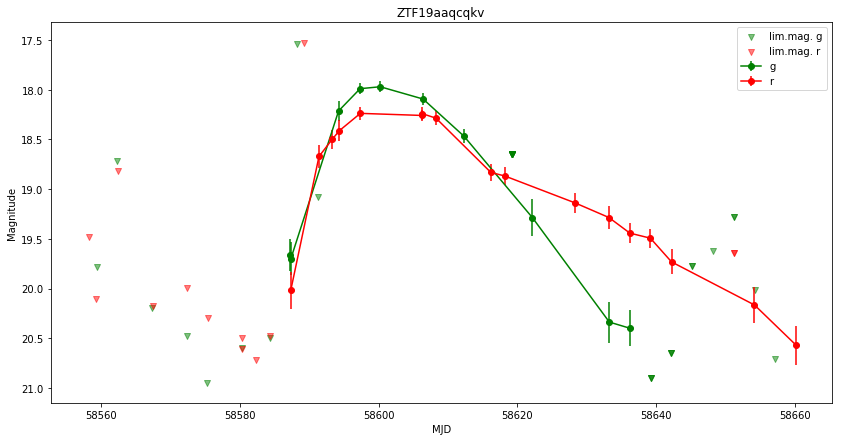

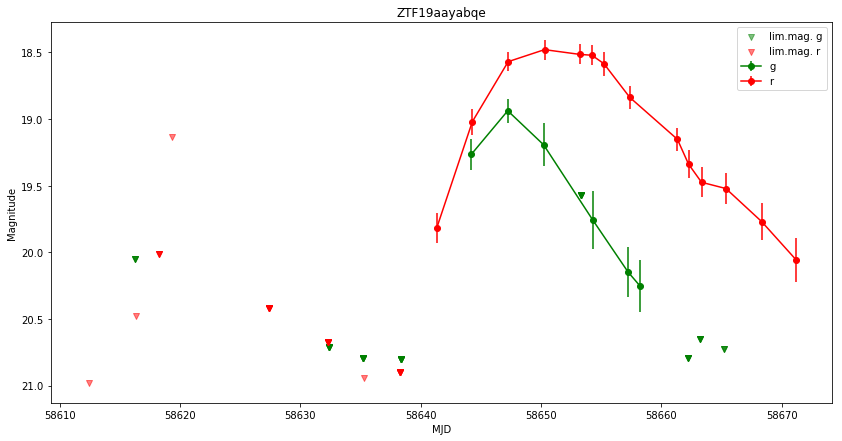

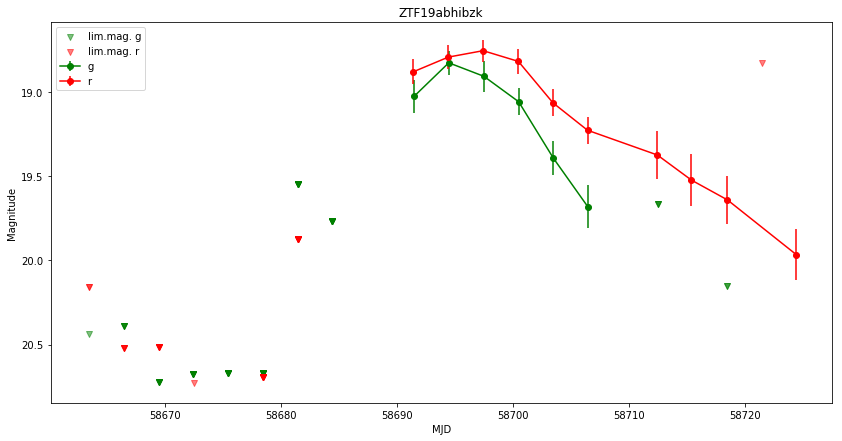

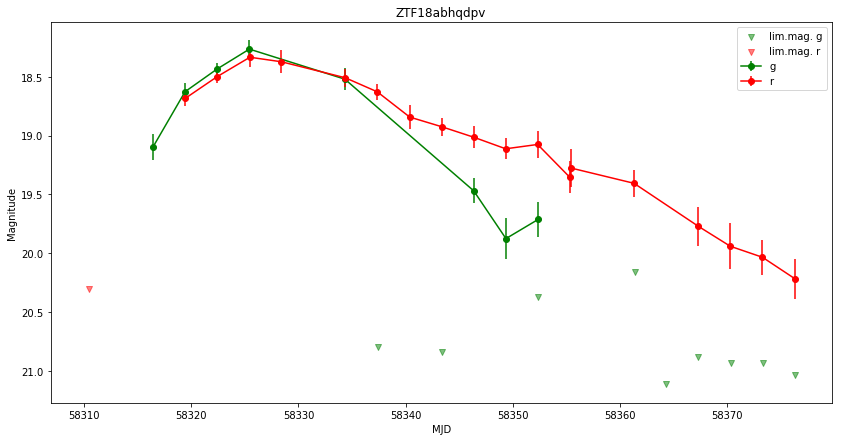

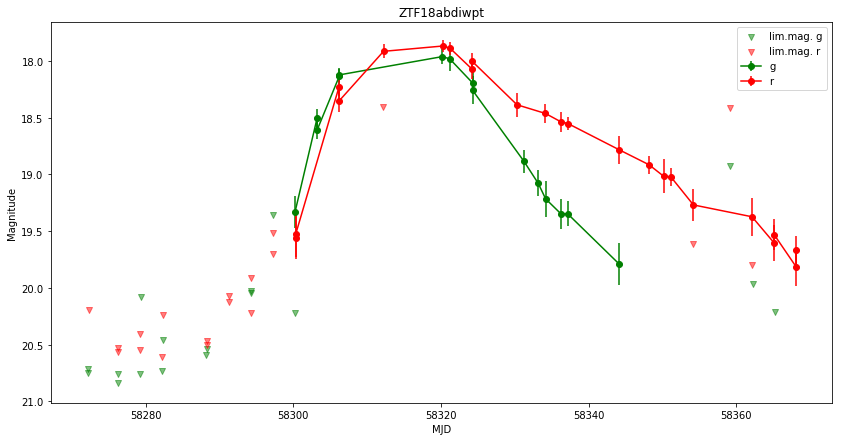

In [15]:
for oid in np.random.choice(SNe.index, size=5):
    getSNdata(oid, doLC = True, dostamp=True, doNED = False);